### Figure 3
* gwas pph4 eqtl vs pc scatterplot
* max egene effect
* frac egene effect
* example gwas coloc

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import upsetplot as up
from scipy.stats import ttest_ind
from matplotlib.colors import LinearSegmentedColormap
import ast


from tqdm.auto import tqdm 
tqdm.pandas()

prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_clusters import * 


%config InlineBackend.figure_formats = ['png']
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 7})

In [24]:
# colors
qtl_palette = {'pcQTL only':'#620059', 'eQTL only':'#6FA286', 'Both':'#614591', 'Neither':'grey'}
corr_cmap = LinearSegmentedColormap.from_list('corr', [(0, '#3e8093ff'), (.5, 'white'), (1, '#c4553aff')])

#### GWAS coloc pp4

In [3]:
coloc_cutoff = .75

In [4]:
gwas_coloc = load_gwas_coloc(config)

File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/coloc/gwas/Skin_Not_Sun_Exposed_Suprapubic/Skin_Not_Sun_Exposed_Suprapubic.v8.EGG_Pubertal_growth_10F.susie_True.gwas_coloc.txt
File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/coloc/gwas/Skin_Not_Sun_Exposed_Suprapubic/Skin_Not_Sun_Exposed_Suprapubic.v8.GEFOS_Forearm.susie_True.gwas_coloc.txt
File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/coloc/gwas/Skin_Not_Sun_Exposed_Suprapubic/Skin_Not_Sun_Exposed_Suprapubic.v8.UKB_G43_Diagnoses_main_ICD10_G43_Migraine.susie_True.gwas_coloc.txt
File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/coloc/gwas/Skin_Not_Sun_Exposed_Suprapubic/Skin_Not_Sun_Exposed_Suprapubic.v8.GPC-NEO-NEUROTICISM.susie_True.gwas_coloc.txt
File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/coloc/gwas/Skin_Not_Sun_Exposed_Suprapubic/Skin_Not_Sun_Exposed_Suprapubic.v8.PGC_ASD_2017_CEU.susie_True.gwas_coloc.txt
File is empty: /home/klawren/oak/

In [5]:
print('Number GWAS loci: {}'.format(len(gwas_coloc[['gwas_id', 'hit1']].drop_duplicates())))
print('Number GWAS variants: {}'.format(len(gwas_coloc[['hit1']].drop_duplicates())))

Number GWAS loci: 19163
Number GWAS variants: 14963


In [6]:
# aggregate at the GWAS variant level

gwas_coloc_e = gwas_coloc[gwas_coloc['type']=='eqtl']
gwas_coloc_pc = gwas_coloc[gwas_coloc['type']=='pcqtl']
max_pph4_indices_e = gwas_coloc_e.groupby(['hit1'])['PP.H4.abf'].idxmax()
max_pph4_indices_pc = gwas_coloc_pc.groupby(['hit1'])['PP.H4.abf'].idxmax()

# set the pp4 to be the max of any pc or egene in the cluster
eqtl_pp4 = gwas_coloc.loc[max_pph4_indices_e, ['gwas_id', 'hit1', 'gwas_tissue_cs_id', 'qtl_id', 'PP.H4.abf']]
pcqtl_pp4 = gwas_coloc.loc[max_pph4_indices_pc, ['gwas_id', 'hit1', 'gwas_tissue_cs_id', 'qtl_id', 'PP.H4.abf']]
pph4_loci = pd.merge(pcqtl_pp4, eqtl_pp4, suffixes=['_pc','_e'], on=['hit1'], how='outer')
pph4_loci[['PP.H4.abf_pc', 'PP.H4.abf_pc']].fillna(0, inplace=True)
pph4_loci['colocalized'] = (pph4_loci['PP.H4.abf_e'] > coloc_cutoff)| (pph4_loci['PP.H4.abf_pc'] >coloc_cutoff )
pph4_loci['coloc_color'] = np.where(pph4_loci['PP.H4.abf_e'] > coloc_cutoff, 
                               np.where(pph4_loci['PP.H4.abf_pc'] >coloc_cutoff, 'Both', 'eQTL only'),
                               np.where(pph4_loci['PP.H4.abf_pc'] >coloc_cutoff, 'pcQTL only', 'Neither'))


/local/scratch/klawren/slrmtmp.48220531/ipykernel_4619/3438157894.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pph4_loci[['PP.H4.abf_pc', 'PP.H4.abf_pc']].fillna(0, inplace=True)


In [7]:
print('Number coloc e: {}'.format((pph4_loci['PP.H4.abf_e']>coloc_cutoff).sum()))
print('Percent coloc e: {}'.format((pph4_loci['PP.H4.abf_e']>coloc_cutoff).mean()*100))

print('Number coloc pc extra: {}'.format((pph4_loci['coloc_color']=='pcQTL only').sum()))
print('Percent coloc pc extra: {}'.format((pph4_loci['coloc_color']=='pcQTL only').mean()*100))

print('Percent increase: {}'.format(((pph4_loci['coloc_color']=='pcQTL only').sum())/((pph4_loci['PP.H4.abf_e']>coloc_cutoff).sum())*100))

Number coloc e: 633
Percent coloc e: 4.230435073180512
Number coloc pc extra: 142
Percent coloc pc extra: 0.9490075519615051
Percent increase: 22.432859399684045


In [8]:
# aggregate at the GWAS-cluster-tissue level

gwas_coloc_e = gwas_coloc[gwas_coloc['type']=='eqtl']
gwas_coloc_pc = gwas_coloc[gwas_coloc['type']=='pcqtl']
max_pph4_indices_e = gwas_coloc_e.groupby(['gwas_tissue_cs_id'])['PP.H4.abf'].idxmax()
max_pph4_indices_pc = gwas_coloc_pc.groupby(['gwas_tissue_cs_id'])['PP.H4.abf'].idxmax()

# set the pp4 to be the max of any pc or egene in the cluster
eqtl_pp4 = gwas_coloc.loc[max_pph4_indices_e, ['gwas_id', 'hit1', 'gwas_tissue_cs_id', 'qtl_id', 'PP.H4.abf']]
pcqtl_pp4 = gwas_coloc.loc[max_pph4_indices_pc, ['gwas_id', 'hit1', 'gwas_tissue_cs_id', 'qtl_id', 'PP.H4.abf']]
pph4 = pd.merge(pcqtl_pp4, eqtl_pp4, suffixes=['_pc','_e'], on=['gwas_tissue_cs_id'], how='outer')
pph4[['PP.H4.abf_pc', 'PP.H4.abf_pc']].fillna(0, inplace=True)
pph4['colocalized'] = (pph4['PP.H4.abf_e'] > coloc_cutoff)| (pph4['PP.H4.abf_pc'] >coloc_cutoff )
pph4['coloc_color'] = np.where(pph4['PP.H4.abf_e'] > coloc_cutoff, 
                               np.where(pph4['PP.H4.abf_pc'] >coloc_cutoff, 'Both', 'eQTL only'),
                               np.where(pph4['PP.H4.abf_pc'] >coloc_cutoff, 'pcQTL only', 'Neither'))


/local/scratch/klawren/slrmtmp.48220531/ipykernel_4619/1056506340.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pph4[['PP.H4.abf_pc', 'PP.H4.abf_pc']].fillna(0, inplace=True)


In [9]:
print('Number coloc e: {}'.format((pph4['PP.H4.abf_e']>coloc_cutoff).sum()))
print('Percent coloc e: {}'.format((pph4['PP.H4.abf_e']>coloc_cutoff).mean()*100))

print('Number coloc pc extra: {}'.format((pph4['coloc_color']=='pcQTL only').sum()))
print('Percent coloc e: {}'.format((pph4['coloc_color']=='pcQTL only').mean()*100))

print('Percent increase: {}'.format(((pph4['coloc_color']=='pcQTL only').sum())/((pph4['PP.H4.abf_e']>coloc_cutoff).sum())*100))

Number coloc e: 1570
Percent coloc e: 1.0378724276298827
Number coloc pc extra: 535
Percent coloc e: 0.3536699036827945
Percent increase: 34.07643312101911


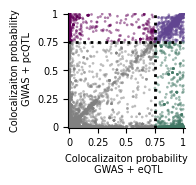

In [11]:
# plot th pp4s
fig, ax = plt.subplots(figsize=(1.5,1.5))
sns.scatterplot(pph4[pph4['coloc_color'].isin(['Neither', 'Both', 'eQTL only', 'pcQTL only'])], x='PP.H4.abf_e', y='PP.H4.abf_pc', hue='coloc_color', ax=ax, s=3, alpha=.5,
             palette=qtl_palette, edgecolor=None,
             hue_order = ['Neither', 'Both', 'eQTL only', 'pcQTL only'], legend=False)
ax.axhline(.75, color='k', linestyle=':', linewidth=2)
ax.axvline(.75, color='k', linestyle=':', linewidth=2)

ax.set_xlabel('Colocalizaiton probability\n GWAS + eQTL')
ax.set_ylabel('Colocalizaiton probability\n GWAS + pcQTL')

ax.set_xlim(-.01, 1.01)
ax.set_ylim(-.01,1.01)

ax.set_xticks([0, .25, .5, .75, 1])
ax.set_xticklabels([0, .25, .5, .75, 1])
ax.set_yticks([0, .25, .5, .75, 1])
ax.set_yticklabels([0, .25, .5, .75, 1])


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# # Change legend title
# leg = ax.get_legend()
# leg.set_title('GWAS-QTL colocalization: ')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)

plt.savefig("/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_3_pp4.pdf", transparent=True)
plt.show()

dict_keys(['matrix', 'shading', 'totals', 'intersections'])


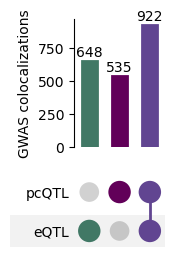

In [12]:
plt.rcParams.update({'font.size': 10})

pph4['pcQTL'] = pph4['PP.H4.abf_pc'] > coloc_cutoff
pph4['eQTL'] = pph4['PP.H4.abf_e'] > coloc_cutoff
upset = pph4[~(pph4['coloc_color']=='Neither')].set_index('eQTL').set_index('pcQTL', append=True)
fig = plt.figure(figsize=(2,3))
upset = up.UpSet(upset, intersection_plot_elements=3, totals_plot_elements = 0, show_counts=True, element_size=None)  # disable the default bar chart
#upset.add_stacked_bars(by="multiple_e_color_label", title="Count", elements=4, colors=('lightgrey', '#67AFD2','#016895'))
upset.style_subsets(present=["eQTL"], absent=["pcQTL"], facecolor=qtl_palette['eQTL only'], linewidth=2)
upset.style_subsets(present=["pcQTL"], absent=["eQTL"], facecolor=qtl_palette['pcQTL only'], linewidth=2)
upset.style_subsets(present=["eQTL", "pcQTL"], facecolor=qtl_palette['Both'], linewidth=2)

# style the instersection plot
plot_result = upset.plot(fig=fig)
print(plot_result.keys())

plot_result['intersections'].set_ylabel("GWAS colocalizations")

plt.savefig("/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_3_upset.pdf", transparent=True)
plt.grid(False)
plt.show()
plt.rcParams.update({'font.size': 7})

### max egene effect

In [13]:
# GWAS QTL colocalization groups
pair_coloc = load_across_tissues(config, load_pairwise_coloc)
gwas_coloc_hits = gwas_coloc[gwas_coloc['PP.H4.abf'] > coloc_cutoff].reset_index()
pair_coloc_hits = pair_coloc[pair_coloc['PP.H4.abf'] > coloc_cutoff].reset_index()
underlying_gwas_signals = get_gwas_signals(gwas_coloc_hits, pair_coloc_hits)
clusters = load_across_tissues(config, load_clusters_annotated)
susie_annotated = load_across_tissues(config, load_susie_annotated)
pair_coloc = load_across_tissues(config, load_pairwise_coloc)
underlying_qtl_signals = load_across_tissues(config, load_signal_groups)

/home/klawren/oak/pcqtls/workflow/scripts/notebook_helper_functions.py:539: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  underlying_signals_explode_gwas['gwas_type'] = underlying_signals_explode_gwas['cs_id'].str.split('gwas_').str[1].str.split('_cs').str[0]


In [ ]:
# merge in max egene effect size to gwas coloc hits
susie_annotated = susie_annotated[~(susie_annotated['egene_id_list'] == '[nan]')]
susie_annotated['egene_qtl_slope'] = susie_annotated['egene_qtl_slope'].progress_apply(ast.literal_eval)
susie_annotated['egene_id_list'] = susie_annotated['egene_id_list'].progress_apply(ast.literal_eval)

# expand out over all egenes for a given qtl
susie_annotated_egene_explode = susie_annotated.explode(['egene_qtl_slope', 'egene_id_list'])

# weight by pip
susie_annotated_egene_explode['pip_weighted_eqtl_slope'] = susie_annotated_egene_explode['egene_qtl_slope']*susie_annotated_egene_explode['pip']

# group by egene
egene_grouped_eqtl_mapped = susie_annotated_egene_explode.groupby(['phenotype_id', 'cs_id', 'tissue_id', 'egene_id_list']).agg({'type':'first',
                                                                                  'cluster_id':'first',
                                                                                  'lead_variant_id':'first',
                                                                                  'pip_weighted_eqtl_slope':sum}).reset_index()

# group by credible set
cs_grouped_eqtl_mapped = egene_grouped_eqtl_mapped.groupby(['phenotype_id', 'cs_id', 'tissue_id']).agg({'type':'first',
                                                                                  'cluster_id':'first',
                                                                                  'lead_variant_id':'first',
                                                                                  'egene_id_list':list,
                                                                                  'pip_weighted_eqtl_slope':list}).reset_index()

cs_grouped_eqtl_mapped['max_egene_effect'] = cs_grouped_eqtl_mapped['pip_weighted_eqtl_slope'].apply(lambda x: max([abs(val) for val in x]))
cs_grouped_eqtl_mapped['var_egene_effect'] = cs_grouped_eqtl_mapped['pip_weighted_eqtl_slope'].apply(np.var)
cs_grouped_eqtl_mapped['sum_egene_effect_squared'] = cs_grouped_eqtl_mapped['pip_weighted_eqtl_slope'].apply(lambda x: sum([(val)**2 for val in x]))
cs_grouped_eqtl_mapped['max_egene_effect_squared'] = cs_grouped_eqtl_mapped['max_egene_effect']**2
cs_grouped_eqtl_mapped['frac_largest_egene_effect'] = cs_grouped_eqtl_mapped['max_egene_effect_squared']/cs_grouped_eqtl_mapped['sum_egene_effect_squared']

# add in the egene effect info
underlying_qtl_signals['cs_id'] = underlying_qtl_signals['signal_id'].str.split('-')
underlying_qtl_signals_explode = underlying_qtl_signals.explode('cs_id')
underlying_qtl_signals_explode = pd.merge(cs_grouped_eqtl_mapped[['cs_id', 'tissue_id', 'max_egene_effect_squared', 'var_egene_effect', 'frac_largest_egene_effect']], underlying_qtl_signals_explode, on=['cs_id', 'tissue_id'], how='right')

# add in number of gwas for each credible set
underlying_gwas_signals_explode = underlying_gwas_signals.explode(['cs_id'])
underlying_gwas_signals_explode['cs_id'] = underlying_gwas_signals_explode['cs_id'].str.split('qtl_').str[1].str.split('_cluster').str[0]
underlying_qtl_signals_explode = pd.merge(underlying_qtl_signals_explode, underlying_gwas_signals_explode[['cs_id', 'tissue_id', 'gwas_type']], on=['cs_id', 'tissue_id'], how='left')
underlying_qtl_signals_explode['gwas_type'] = underlying_qtl_signals_explode['gwas_type'].fillna(0)

underlying_qtl_signals_egene_effect = underlying_qtl_signals_explode.groupby(['signal_id', 'tissue_id']).agg({'max_egene_effect_squared':'max', 
                                                                         'num_e_coloc':'first',
                                                                         'num_pc_coloc':'first',
                                                                         'var_egene_effect':'max',
                                                                         'frac_largest_egene_effect':'max', 
                                                                         'gwas_type':'max'})

underlying_qtl_signals_egene_effect = underlying_qtl_signals_egene_effect.reset_index()
underlying_qtl_signals_egene_effect = underlying_qtl_signals_egene_effect[~underlying_qtl_signals_egene_effect['max_egene_effect_squared'].isna()]
underlying_qtl_signals_egene_effect['exclusive_label'] = np.where((underlying_qtl_signals_egene_effect['num_e_coloc'] > 0), np.where((underlying_qtl_signals_egene_effect['num_pc_coloc'] > 0), 'Both', 'eQTL only'), 'pcQTL only')

In [ ]:
# qtl max egene effect split by type
fig, ax = plt.subplots(figsize=(2, 2))
sns.violinplot(underlying_qtl_signals_egene_effect, x='has_coloc', y='max_egene_effect_squared',
               common_norm=False, cut=0, log_scale=True, hue='has_coloc', ax=ax, palette=['grey', 'k'], fill=False, legend=False)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('Largest eGene effect')
plt.savefig(f"/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_3_max_effect_coloc.pdf", transparent=True)
print(ttest_ind(underlying_qtl_signals_egene_effect[~underlying_qtl_signals_egene_effect['has_coloc']]['max_egene_effect_squared'], underlying_qtl_signals_egene_effect[underlying_qtl_signals_egene_effect['has_coloc']]['max_egene_effect_squared']))

In [ ]:
# run a model looking at gwas pliotropy controling for egene effect size
underlying_qtl_signals_egene_effect['log_max_effect'] = np.log10(underlying_qtl_signals_egene_effect['max_egene_effect_squared'])
underlying_qtl_signals_egene_effect['has_coloc'] = underlying_qtl_signals_egene_effect['gwas_type']>0

X = underlying_qtl_signals_egene_effect[['log_max_effect']]
y = underlying_qtl_signals_egene_effect['has_coloc']
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())
model.pvalues

### frac egene effect

In [ ]:
fig, ax = plt.subplots(figsize=(1.5, 2))
sns.violinplot(underlying_qtl_signals_egene_effect, y='frac_largest_egene_effect', x='has_coloc',  hue='has_coloc', fill=False, palette=['grey', 'k'], legend=False, ax=ax, cut=0)
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel('Fraction effect in largest eGene')
ax.set_ylim([0,1])
ax.set_yticks([0, .25, .5, .75, 1])
plt.savefig(f"/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_3_frac_effect_coloc.pdf", transparent=True)
print(ttest_ind(underlying_qtl_signals_egene_effect[~underlying_qtl_signals_egene_effect['has_coloc']]['frac_largest_egene_effect'], underlying_qtl_signals_egene_effect[underlying_qtl_signals_egene_effect['has_coloc']]['frac_largest_egene_effect']))

In [ ]:
# run a model looking at gwas pliotropy controling for egene effect size

X = underlying_qtl_signals_egene_effect[['frac_largest_egene_effect', 'log_max_effect']]
y = underlying_qtl_signals_egene_effect['has_coloc']
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())
model.pvalues

### example with hox genes 

signal_id = 'gwas_GIANT_HEIGHT_cs_5_cluster_ENSG00000108511.9_ENSG00000120068.6_ENSG00000120075.5_ENSG00000120093.11_ENSG00000182742.5_ENSG00000260027.4_tissue_Esophagus_Muscularis-qtl_ENSG00000108511.9_ENSG00000120068.6_ENSG00000120075.5_ENSG00000120093.11_ENSG00000182742.5_ENSG00000260027.4_pc4_cs_2_cluster_ENSG00000108511.9_ENSG00000120068.6_ENSG00000120075.5_ENSG00000120093.11_ENSG00000182742.5_ENSG00000260027.4_tissue_Esophagus_Muscularis'


ids corresplond to 
* ENSG00000182742.5 = hoxb4
* ENSG00000120093.11 = hoxb3
* ENSG00000120075.5 = hoxb5
* ENSG00000108511.9 = hoxb6
* ENSG00000120068.6 = hoxb8
* ENSG00000260027.4 = hoxb7

In [14]:
example_signal_id = 'gwas_GIANT_HEIGHT_cs_5_cluster_ENSG00000108511.9_ENSG00000120068.6_ENSG00000120075.5_ENSG00000120093.11_ENSG00000182742.5_ENSG00000260027.4_tissue_Esophagus_Muscularis-qtl_ENSG00000108511.9_ENSG00000120068.6_ENSG00000120075.5_ENSG00000120093.11_ENSG00000182742.5_ENSG00000260027.4_pc4_cs_2_cluster_ENSG00000108511.9_ENSG00000120068.6_ENSG00000120075.5_ENSG00000120093.11_ENSG00000182742.5_ENSG00000260027.4_tissue_Esophagus_Muscularis'
example_cs_id = 'ENSG00000108511.9_ENSG00000120068.6_ENSG00000120075.5_ENSG00000120093.11_ENSG00000182742.5_ENSG00000260027.4_pc4_cs_2'
example_gwas_id = 'GIANT_HEIGHT_cs_5_cluster_ENSG00000108511.9_ENSG00000120068.6_ENSG00000120075.5_ENSG00000120093.11_ENSG00000182742.5_ENSG00000260027.4'

In [15]:
example_coloc = underlying_gwas_signals[underlying_gwas_signals['signal_id'] == example_signal_id].iloc[0]
example_cs = susie_annotated[susie_annotated['cs_id'] == example_cs_id]
example_var = example_cs.iloc[0]

In [16]:
example_cs

,phenotype_id,variant_id,cs_id,type,pip,cluster_id,start_distance,end_distance,af,ma_samples,...,num_tads_qtl,qtl_in_tad,between_tss,qtl_in_tss_ctcf,qtl_in_tad_ctcf,in_bidirectional_promoter,in_shared_promoter,cluster_min_distance,cs_num,lead_variant_id
349060,ENSG00000108511.9_ENSG00000120068.6_ENSG000001...,chr17_48575675_AT_A_b38,ENSG00000108511.9_ENSG00000120068.6_ENSG000001...,pcqtl,0.070539,ENSG00000108511.9_ENSG00000120068.6_ENSG000001...,-3954.0,-57897.0,0.115054,98.0,...,1,False,False,False,False,False,True,3954,2,chr17_48584210_C_T_b38
349061,ENSG00000108511.9_ENSG00000120068.6_ENSG000001...,chr17_48578586_C_T_b38,ENSG00000108511.9_ENSG00000120068.6_ENSG000001...,pcqtl,0.224521,ENSG00000108511.9_ENSG00000120068.6_ENSG000001...,-1043.0,-54986.0,0.083871,73.0,...,1,False,False,False,False,False,True,1043,2,chr17_48584210_C_T_b38
349062,ENSG00000108511.9_ENSG00000120068.6_ENSG000001...,chr17_48584210_C_T_b38,ENSG00000108511.9_ENSG00000120068.6_ENSG000001...,pcqtl,0.684096,ENSG00000108511.9_ENSG00000120068.6_ENSG000001...,4581.0,-49362.0,0.086022,75.0,...,1,False,True,False,False,False,True,-4581,2,chr17_48584210_C_T_b38


In [17]:
# all QTLs in the cluster
underlying_qtl_signals[(underlying_qtl_signals['cluster_id']==example_coloc['cluster_id'])]['signal_id'].values

array(['ENSG00000108511.9_ENSG00000120068.6_ENSG00000120075.5_ENSG00000120093.11_ENSG00000182742.5_ENSG00000260027.4_pc4_cs_2',
       'ENSG00000108511.9_ENSG00000120068.6_ENSG00000120075.5_ENSG00000120093.11_ENSG00000182742.5_ENSG00000260027.4_e_ENSG00000120093.11_cs_1'],
      dtype=object)

In [18]:
# both qtls coloc with the GwAS
gwas_coloc[(gwas_coloc['cluster_id']==example_coloc['cluster_id']) & (gwas_coloc['gwas_cs_id']==example_gwas_id)]


,gwas_id,qtl_id,nsnps,hit1,hit2,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,...,gwas_cs_is,qtl_cs_is,tissue_id,coloc_file,cluster_id,gwas_cs_id,qtl_cs_id,type,gwas_tissue_cs_id,qtl_tissue_cs_id
251003,GIANT_HEIGHT,ENSG00000108511.9_ENSG00000120068.6_ENSG000001...,1160.0,chr17_48584210_C_T_b38,chr17_48583930_G_A_b38,2.474220e-51,0.000431,5.743579e-48,0.999522,0.000047,...,5.0,1.0,Esophagus_Muscularis,/home/klawren/oak/pcqtls/output/proteincoding_...,ENSG00000108511.9_ENSG00000120068.6_ENSG000001...,GIANT_HEIGHT_cs_5_cluster_ENSG00000108511.9_EN...,ENSG00000108511.9_ENSG00000120068.6_ENSG000001...,eqtl,gwas_GIANT_HEIGHT_cs_5_cluster_ENSG00000108511...,qtl_ENSG00000108511.9_ENSG00000120068.6_ENSG00...
251012,GIANT_HEIGHT,ENSG00000108511.9_ENSG00000120068.6_ENSG000001...,1160.0,chr17_48584210_C_T_b38,chr17_48584210_C_T_b38,2.217776e-52,0.000039,1.154191e-50,0.000009,0.999953,...,5.0,2.0,Esophagus_Muscularis,/home/klawren/oak/pcqtls/output/proteincoding_...,ENSG00000108511.9_ENSG00000120068.6_ENSG000001...,GIANT_HEIGHT_cs_5_cluster_ENSG00000108511.9_EN...,ENSG00000108511.9_ENSG00000120068.6_ENSG000001...,pcqtl,gwas_GIANT_HEIGHT_cs_5_cluster_ENSG00000108511...,qtl_ENSG00000108511.9_ENSG00000120068.6_ENSG00...


In [21]:
# bring in the nominal p values
nominal_e = load_e_nominal(config, example_var['tissue_id'], example_var['chr'])
nominal_pc = load_pc_nominal(config, example_var['tissue_id'], example_var['chr'])

# bring in gwas summary stats
gwas_path = '/oak/stanford/groups/smontgom/shared/gwas_summary_stats/barbeira_gtex_imputed/imputed_gwas_hg38_1.1/imputed_GIANT_HEIGHT.txt.gz'
example_gwas = pd.read_csv(gwas_path, sep='\t')

pc4_pvalues = nominal_pc[(nominal_pc['cluster_id'] == example_coloc['cluster_id']) & (nominal_pc['pc_num']==4)][['variant_id', 'pval_nominal']]
gwas_pc4_pvalues_merged = pd.merge(pc4_pvalues, example_gwas[['panel_variant_id', 'pvalue']], left_on='variant_id', right_on='panel_variant_id', how='inner')

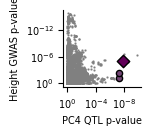

In [ ]:
fig, ax = plt.subplots(figsize=(1, 1))

sns.scatterplot(gwas_pc4_pvalues_merged, x='pval_nominal', y='pvalue', s=2, alpha=1, edgecolor=None, ax=ax, color='grey')
sns.scatterplot(gwas_pc4_pvalues_merged[gwas_pc4_pvalues_merged['variant_id'].isin(example_cs['variant_id'])], x='pval_nominal', y='pvalue', s=20, alpha=1, linewidth=1, edgecolor='k', ax=ax, color='#734675')
sns.scatterplot(gwas_pc4_pvalues_merged[gwas_pc4_pvalues_merged['variant_id'].isin(example_cs['lead_variant_id'])], x='pval_nominal', y='pvalue', s=40, alpha=1, linewidth=1, edgecolor='k', ax=ax, color='#620059', marker='D')

ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xscale('log')
ax.set_yscale('log')
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('PC4 QTL p-value')
ax.set_ylabel('Height GWAS p-value')
ax.set_xticks([1e0, 1e-4, 1e-8])
ax.set_yticks([1e0, 1e-6, 1e-12])

plt.savefig("/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_3_hox_pc4.pdf", transparent=True)

plt.show()

In [ ]:
def plot_egene_coloc(gene_name, example_egene_id, nominal_e, example_gwas, color_light, color_dark):
    egene_pvalues = nominal_e[(nominal_e['cluster_id'] == example_coloc['cluster_id']) & (nominal_e['egene_id']==example_egene_id)][['variant_id', 'pval_nominal']]
    gwas_egene_pvalues_merged = pd.merge(egene_pvalues, example_gwas[['panel_variant_id', 'pvalue']], left_on='variant_id', right_on='panel_variant_id', how='inner')

    fig, ax = plt.subplots(figsize=(1, 1))

    sns.scatterplot(gwas_egene_pvalues_merged, x='pval_nominal', y='pvalue', s=2, alpha=1, edgecolor=None, ax=ax, color='grey')
    sns.scatterplot(gwas_egene_pvalues_merged[gwas_egene_pvalues_merged['variant_id'].isin(example_cs['variant_id'])], x='pval_nominal', y='pvalue', s=20, alpha=1, linewidth=1, edgecolor='k', ax=ax, color=color_light)
    sns.scatterplot(gwas_egene_pvalues_merged[gwas_egene_pvalues_merged['variant_id'].isin(example_cs['lead_variant_id'])], x='pval_nominal', y='pvalue', s=40, alpha=1, linewidth=1, edgecolor='k', ax=ax, color=color_dark, marker='D')

    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel(f'{gene_name} eQTL p-value')
    ax.set_ylabel('Height GWAS p-value')
    ax.set_xticks([1e0, 1e-4, 1e-8])
    ax.set_yticks([1e0, 1e-6, 1e-12])
    plt.savefig(f"/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_3_hox_{gene_name}.pdf", transparent=True)
    plt.show()

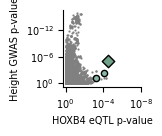

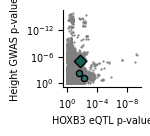

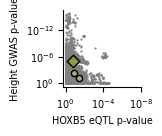

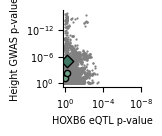

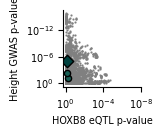

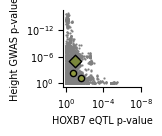

In [ ]:
plot_egene_coloc('HOXB4', 'ENSG00000182742.5', nominal_e, example_gwas,'#8AB8A7', '#6FA287')
plot_egene_coloc('HOXB3', 'ENSG00000120093.11', nominal_e, example_gwas,'#2D716F', '#175E54')
plot_egene_coloc('HOXB5', 'ENSG00000120075.5', nominal_e, example_gwas,'#A6B168', '#8F993E')
plot_egene_coloc('HOXB6', 'ENSG00000108511.9', nominal_e, example_gwas,'#6FA287', '#417865')
plot_egene_coloc('HOXB8', 'ENSG00000120068.6', nominal_e, example_gwas,'#175E54', '#014240')
plot_egene_coloc('HOXB7', 'ENSG00000260027.4', nominal_e, example_gwas,'#8F993E', '#7A863B')

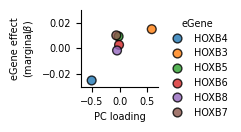

In [ ]:
# plot QTL slopes vs effects

qtl_slopes = example_cs['egene_qtl_slope'].apply(ast.literal_eval).values
pip_weighted_qtl_slopes = np.asarray([np.asarray(qtl_slopes[i])*example_cs['pip'].iloc[i] for i in range(len(qtl_slopes))])
pip_weighted_qtl_slopes = pip_weighted_qtl_slopes.sum(axis=0)/example_cs['pip'].sum()

fig, ax = plt.subplots(figsize=(1, 1))
palette=['#6FA287', '#175E54', '#8F993E','#417865', '#014240', '#7A863B']
hox_cluster_loadings = pd.DataFrame({'beta':pip_weighted_qtl_slopes, 
              'loading':ast.literal_eval(example_cs['egene_pc_slope'].iloc[0]), 
              'egene_id':['HOXB4', 'HOXB3', 'HOXB5', 'HOXB6', 'HOXB8', 'HOXB7']})
hox_cluster_loadings['loading'] = hox_cluster_loadings['loading']*-1

sns.scatterplot(hox_cluster_loadings, x='loading', y='beta', s=40, linewidth=1, edgecolor='k', hue='egene_id', color='#417865', alpha=.8)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('PC loading')
ax.set_ylabel('eGene effect\n'+r'(marginal$\beta)$')
ax.legend(frameon=False, title='eGene')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlim([-.7, .7])
ax.set_ylim([-.03, .03])
plt.savefig(f"/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_3_hox_pc_loadings.pdf", transparent=True)
plt.show()

In [ ]:
# load in abc data
abc = pd.read_csv('/home/klawren/oak/pcqtls/data/references/functional_annotations/ABC_predictions/ABC.hg38.bed', sep='\t')

In [ ]:
example_var = example_cs.iloc[0]
abc[(abc['chr'] == 'chr{}'.format(example_var['chr'])) & (abc['start'] < example_var['position']) & (abc['end'] > example_var['position'])]

,chr,start,end,name,class,activity_base,TargetGene,TargetGeneTSS,TargetGeneExpression,TargetGenePromoterActivityQuantile,...,powerlaw_contact,powerlaw_contact_reference,hic_contact_pl_scaled,hic_pseudocount,hic_contact_pl_scaled_adj,ABC.Score.Numerator,ABC.Score,powerlaw.Score.Numerator,powerlaw.Score,CellType
6281910,chr17,48575074,48576404,promoter|chr17:46652286-46653916,promoter,11.944812,HOXB3,46651810,NaN,0.606485,...,0.125372,0.123436,0.036137,0.001216,0.037353,0.446171,0.100597,1.474420,0.160100,astrocyte-ENCODE
6281911,chr17,48575383,48575819,genic|chr17:46652595-46653331,genic,2.217736,HOXB4,46655743,NaN,0.558212,...,0.125372,0.123436,0.026634,0.001216,0.027850,0.061763,0.015667,0.273749,0.040875,coronary_artery-ENCODE
6281912,chr17,48575419,48575811,genic|chr17:46652631-46653323,genic,5.523973,HOXB4,46655743,NaN,0.657732,...,0.125372,0.123436,0.026634,0.001216,0.027850,0.153841,0.032830,0.681857,0.066864,adipose_tissue-ENCODE


In [ ]:
example_var = example_cs.iloc[1]
abc[(abc['chr'] == 'chr{}'.format(example_var['chr'])) & (abc['start'] < example_var['position']) & (abc['end'] > example_var['position'])]

,chr,start,end,name,class,activity_base,TargetGene,TargetGeneTSS,TargetGeneExpression,TargetGenePromoterActivityQuantile,...,powerlaw_contact,powerlaw_contact_reference,hic_contact_pl_scaled,hic_pseudocount,hic_contact_pl_scaled_adj,ABC.Score.Numerator,ABC.Score,powerlaw.Score.Numerator,powerlaw.Score,CellType
6281982,chr17,48577982,48578659,promoter|chr17:46655194-46656171,promoter,8.666681,HOXB4,46655743,NaN,0.694191,...,0.125372,0.123436,0.036149,0.001216,0.037365,0.323833,0.109633,1.069781,0.229019,BJAB_anti-IgM_anti-CD40_4hr-Engreitz


In [ ]:
example_var = example_cs.iloc[2]
abc[(abc['chr'] == 'chr{}'.format(example_var['chr'])) & (abc['start'] < example_var['position']) & (abc['end'] > example_var['position'])]

,chr,start,end,name,class,activity_base,TargetGene,TargetGeneTSS,TargetGeneExpression,TargetGenePromoterActivityQuantile,...,powerlaw_contact,powerlaw_contact_reference,hic_contact_pl_scaled,hic_pseudocount,hic_contact_pl_scaled_adj,ABC.Score.Numerator,ABC.Score,powerlaw.Score.Numerator,powerlaw.Score,CellType
6282104,chr17,48584076,48584823,intergenic|chr17:46661288-46662335,intergenic,7.618595,HOXB2,46622393,NaN,0.401377,...,0.020589,0.020481,0.008191,0.001216,0.009407,0.071666,0.019156,0.156037,0.028525,LoVo
6282105,chr17,48584076,48584823,intergenic|chr17:46661288-46662335,intergenic,7.618595,HOXB-AS3,46667781,NaN,0.643433,...,0.107366,0.105802,0.039989,0.001216,0.041205,0.313920,0.062147,0.806059,0.081355,LoVo
6282106,chr17,48584076,48584823,intergenic|chr17:46661288-46662335,intergenic,7.618595,HOXB5,46671103,NaN,0.434170,...,0.072905,0.072002,0.015142,0.001216,0.016358,0.124627,0.026255,0.548556,0.057101,LoVo
